# Рынок заведений общественного питания Москвы

## Описание проекта

Необходимо проанализировать рынок заведений общественного питания в Москве.

У вас есть открытые данные о заведениях общественного питания в Москве.

## Описание данных

Таблица rest_data:

    id — идентификатор объекта;
    object_name — название объекта общественного питания;
    chain — сетевой ресторан;
    object_type — тип объекта общественного питания;
    address — адрес;
    number — количество посадочных мест.

## План выполнения

1. [Выгрузка данных и подготовка их к анализу](#step_1)
2. Анализ данных:
    - [Соотношение видов объектов общественного питания по количеству](#step_2) 
    - [Соотношение сетевых и несетевых заведений по количеству](#step_3) 
    - [Сетевое или не сетевые заведения](#step_4)  
    - [Характеристика сетевых заведений много заведений](#step_5) 
    - [Исследование среднего количества посадочных мест](#step_6) 
    - [Выделение улицы, на которой находится заведение](#step_7) 
    - [Топ-10 улиц по количеству объектов общественного питания(с использованием ручного поиска информации)](#step_8) 
    - [Число улиц с одним объектом общественного питания(автоматизированный поиск информации)](#step_9) 
    - [Распределение количества посадочных мест для улиц с большим количеством объектов общественного питания](#step_10)  
3. [Общий вывод](#step_11) 

### Выгрузка данных и подготовка их к анализу

<a id='step_1'></a>

In [1]:
# Импортирование необходимых библиотек
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import math
import seaborn as sns
from pymystem3 import Mystem
from collections import Counter
import plotly.express as px

In [2]:
# Данные о заведениях общественного питания Москвы
rest_data = pd.read_csv('')
rest_data.head()

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


In [3]:
rest_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
id             15366 non-null int64
object_name    15366 non-null object
chain          15366 non-null object
object_type    15366 non-null object
address        15366 non-null object
number         15366 non-null int64
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


Все типы данных соответствуют переменным. Считаю, что стоит заменить в столбце chain значения с "да-нет" на "1-0" и тип данных bool.

In [4]:
rest_data.loc[(rest_data['chain'] == 'да'),'chain'] = 1
rest_data.loc[(rest_data['chain'] == 'нет'),'chain'] = 0
rest_data['chain'] = rest_data['chain'].astype(bool)

In [5]:
rest_data

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,False,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,False,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,False,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,True,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,False,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50
...,...,...,...,...,...,...
15361,208537,Шоколадница,True,кафе,"город Москва, 3-й Крутицкий переулок, дом 18",50
15362,209264,Шоколадница,True,кафе,"город Москва, улица Земляной Вал, дом 33",10
15363,209186,Шоколадница,True,кафе,"город Москва, улица Земляной Вал, дом 33",20
15364,221900,Шоколадница,True,кафе,"город Москва, поселение Московский, Киевское ш...",36


В конце таблицы с данными видно, что существуют дубликаты. Но у них различны id и number. Необходимо обнаружить и обработать эти дубликаты.

In [6]:
# Проверка на дубликаты
print('Дубликатов в данных',rest_data[['object_name','address']].duplicated().sum())

Дубликатов в данных 207


In [7]:
# Удаление дубликатов
rest_data = rest_data.drop_duplicates(subset = ['object_name','address']).reset_index(drop = True)
print('Дубликатов в данных',rest_data[['object_name','address']].duplicated().sum())

Дубликатов в данных 0


In [8]:
rest_data['object_type'].value_counts()

кафе                                 6003
столовая                             2572
ресторан                             2272
предприятие быстрого обслуживания    1886
бар                                   850
буфет                                 567
кафетерий                             392
закусочная                            345
магазин (отдел кулинарии)             272
Name: object_type, dtype: int64

В столбце с типами заведений всё выглядиит корректно: типы не повторяются и регистры записей одинаковые.

In [9]:
rest_data['object_name'].value_counts().head(30)

Столовая                    266
Шаурма                      224
Кафе                        201
KFC                         152
Шоколадница                 140
Бургер Кинг                 121
Макдоналдс                  118
Домино'с Пицца               86
Теремок                      83
Крошка Картошка              81
Пекарня                      74
Милти                        65
Суши Wok                     61
СТОЛОВАЯ                     52
Буфет                        52
Папа Джонс                   50
Школьно-базовая столовая     44
Кофе с собой                 41
Чайхона №1                   40
КАФЕ                         39
Выпечка                      36
Хинкальная                   35
Якитория                     33
Кафетерий                    32
Додо Пицца                   31
Subway                       29
МАКДОНАЛДС                   29
Кофе Хаус                    29
Кофейня                      29
Starbucks                    28
Name: object_name, dtype: int64

В столбце с названиями кафе всё немного хуже: различные регистры, записи транслитом и другие проблемы. Сначала приведём всё к одному нижнему регистру.

In [10]:
rest_data['object_name'] = rest_data['object_name'].str.lower()

In [11]:
rest_data['object_name'].value_counts().head(50)

столовая                               320
кафе                                   241
шаурма                                 240
шоколадница                            156
kfc                                    152
макдоналдс                             147
бургер кинг                            136
теремок                                 93
домино'с пицца                          90
крошка картошка                         89
пекарня                                 80
буфет                                   75
суши wok                                72
милти                                   72
папа джонс                              51
додо пицца                              49
школьно-базовая столовая                44
кофе с собой                            43
чайхона №1                              41
донер кебаб                             41
хинкальная                              38
якитория                                38
кафетерий                               37
выпечка    

Объединим некоторые повторяющиеся названия, создав функцию.

In [12]:
def translit_name (name):
    if 'starbucks' in name or 'старбакс' in name:
        return 'starbucks'
    if 'школ' in name or 'лицей' in name or 'гимназ' in name or 'шк' in name:
        return 'школьная столовая' 
    if 'pizza hut' in name or 'пицца хат' in name:
        return 'pizza hut' 
    if 'макдоналдс' in name or 'McDonald' in name:
        return 'макдоналдс'
    if 'сабвей' in name or 'subway' in name:
        return 'макдоналдс'
    if 'колледж' in name or 'школьн' in name:
        return 'столовая при колледже' 
    if 'шаурма' in name:
        return 'шаурма' 
    return name


rest_data['object_name'] = rest_data['object_name'].apply(translit_name) 

In [13]:
quantity_of_rest = rest_data['object_name'].nunique()
print('Количество различных заведений',rest_data['object_name'].nunique())
rest_data['object_name'].value_counts().head(30)

Количество различных заведений 8666


школьная столовая        1438
шаурма                    359
столовая                  320
кафе                      241
макдоналдс                229
шоколадница               156
kfc                       152
бургер кинг               136
столовая при колледже     114
теремок                    93
домино'с пицца             90
пекарня                    80
буфет                      75
милти                      72
суши wok                   72
starbucks                  69
папа джонс                 51
додо пицца                 49
кофе с собой               43
донер кебаб                41
чайхона №1                 41
якитория                   38
хинкальная                 38
кафетерий                  37
выпечка                    36
кофе хаус                  33
кофейня                    33
тануки                     32
хлеб насущный              32
pizza hut                  28
Name: object_name, dtype: int64

У некоторых одноимённых заведений вписаны различные типы. Надо привести их к наиболее популярному варианту.

In [14]:
popular_objects = list(rest_data.groupby('object_name').agg({'number':'count'})
                       .reset_index().sort_values(by='number',ascending=False).head(quantity_of_rest)['object_name'].unique())
popular_objects

['школьная столовая',
 'шаурма',
 'столовая',
 'кафе',
 'макдоналдс',
 'шоколадница',
 'kfc',
 'бургер кинг',
 'столовая при колледже',
 'теремок',
 "домино'с пицца",
 'пекарня',
 'буфет',
 'суши wok',
 'милти',
 'starbucks',
 'папа джонс',
 'додо пицца',
 'кофе с собой',
 'донер кебаб',
 'чайхона №1',
 'якитория',
 'хинкальная',
 'кафетерий',
 'выпечка',
 'кофе хаус',
 'кофейня',
 'хлеб насущный',
 'тануки',
 'pizza hut',
 'прайм стар',
 'cofix',
 'иль патио',
 'мята lounge',
 'му-му',
 'пиццерия',
 'бистро',
 'кулинария',
 'донер',
 'андерсон',
 'бар',
 'кафе «шоколадница»',
 'кофе',
 'кулинарная лавка братьев караваевых',
 'чайхона',
 'пицца паоло',
 'французская пекарня',
 'сушишоп',
 'кофемания',
 'алло пицца',
 'азбука вкуса',
 'чайхана',
 'кружка',
 'стардогs',
 'вьетнамская кухня',
 'штолле',
 'кальянная',
 'суши сет',
 'суши вок',
 'суши',
 'баскин роббинс',
 'кафе «хинкальная»',
 'шаверма',
 'волконский',
 'кебаб',
 'ресторан «тануки»',
 'ваби-саби',
 'столовая «ооо вито-1»',

In [15]:
# таблица соответствия названий заведений и их типа
object_type_pivot = rest_data.query('object_name in @popular_objects').pivot_table(index = ['object_name','object_type'], 
                                                                                   values = 'number',
                                                                                  aggfunc = 'count').sort_values(by = 'number',
                                                                                                                ascending = False).reset_index().head(quantity_of_rest)
object_type_pivot.head()

,object_name,object_type,number
0,школьная столовая,столовая,1104
1,столовая,столовая,307
2,шаурма,предприятие быстрого обслуживания,221
3,кафе,кафе,209
4,школьная столовая,буфет,159


In [16]:
# создание словаря с наиболее популярным для него типом заведения
object_types_list = object_type_pivot.groupby('object_name').agg({'object_type':'first'}).reset_index()
object_types_list = object_types_list.rename(columns = {'object_type':'new_object_type'})
object_types_list.head()

,object_name,new_object_type
0,1-ый московский кадетский корпус,столовая
1,100 личная столовая,столовая
2,100 личное кафе,кафе
3,1001 ночь,ресторан
4,100лоффка,столовая


In [17]:
# Объединяем это с исходной таблицей
rest_data = rest_data.merge(object_types_list[['object_name','new_object_type']], on = 'object_name', how = 'left')
rest_data.head()

,id,object_name,chain,object_type,address,number,new_object_type
0,151635,сметана,False,кафе,"город Москва, улица Егора Абакумова, дом 9",48,кафе
1,77874,родник,False,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,кафе
2,24309,кафе «академия»,False,кафе,"город Москва, Абельмановская улица, дом 6",95,NaN
3,21894,пиццетория,True,кафе,"город Москва, Абрамцевская улица, дом 1",40,кафе
4,119365,кафе «вишневая метель»,False,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,NaN


### Анализ данных

**Исследуем соотношение видов объектов общественного питания по количеству.**

<a id='step_2'></a>

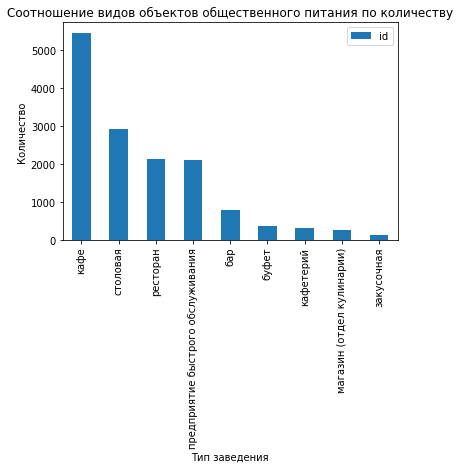

In [18]:
rest_data.groupby('new_object_type').agg({'id':'count'}).sort_values(by='id', ascending=False).plot(kind='bar', 
                                                                                title='Соотношение видов объектов общественного питания по количеству',
                                                                                  legend=True)
plt.ylabel('Количество')
plt.xlabel('Тип заведения')
plt.show()

<div class="alert alert-success">
<b>Комментарий ревьюера:</b>

Отличный и наглядный график 👍
    
Здорово, когда он подписан. Так быстрее понять о чем идёт речь на нём.
    
</div>

Чаще всего встречаются в Москве кафе. Столовые при учебных учереждениях и предприятиях занимают второе место по частоте. Реже всего можно наткнуться на закусочные и кафетерии.

**Исследуем соотношение сетевых и не сетевых заведений по количеству**

<a id='step_3'></a>

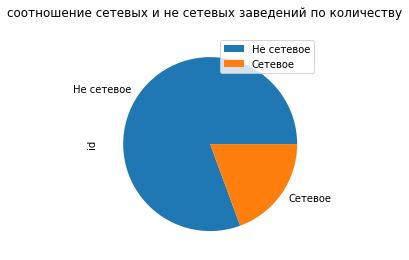

In [19]:
labels = ['Не сетевое','Сетевое']
rest_data.groupby('chain').agg({'id':'count'}).sort_values(by='id', ascending=False).plot(subplots=True,kind='pie', labels=labels,
                                                                                title='соотношение сетевых и не сетевых заведений по количеству',
                                                                                  legend=True)

plt.show()

Не сетевых заведений в Москве значительно больше, сетевые занимают пятую долю от исследуемого объёма.

**Для какого вида объекта общественного питания характерно сетевое распространение**

<a id='step_4'></a>

In [20]:
rest_data = rest_data.dropna()

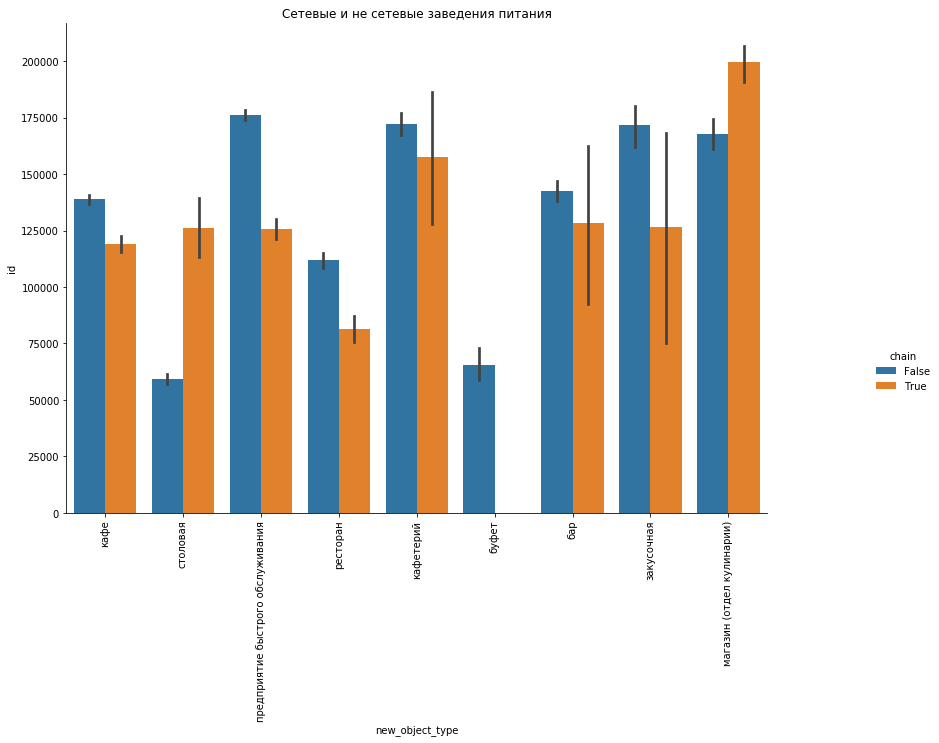

In [21]:
df_plot = rest_data#.groupby(['new_object_type', 'chain']).agg({'id':'count'})
g = sns.catplot(data = df_plot, kind = 'bar', x ='new_object_type', y = 'id', hue = 'chain')
g.fig.set_size_inches(15,8)
plt.xticks(rotation='vertical')
plt.title('Сетевые и не сетевые заведения питания')
plt.show()



В среднем все заведения питания встречаются как в виде сетей, так и нет. Столовые и отделы кулинарии чаще бывают сетевыми. А вот буфет или закусочную сетевую встретить сложнее.

**Что характерно для сетевых заведений: много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест**

<a id='step_5'></a>

In [22]:
df_scatter_plot = rest_data.query('chain == True').groupby('object_name').agg({'id':'count', 'number':'mean'})
df_scatter_plot

,id,number
object_name,,
beverly hills diner,1,88.000000
bierloga,1,75.000000
black & white,1,40.000000
bocconcino,3,66.666667
boobo,1,46.000000
...,...,...
ямми микс,1,2.000000
ян примус,1,300.000000
японский ресторан «ваби-саби»,1,155.000000


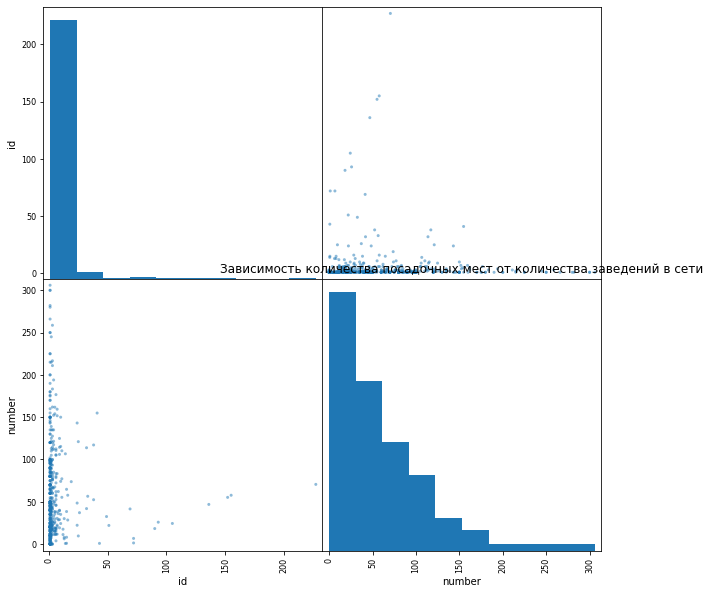

In [23]:
pd.plotting.scatter_matrix(df_scatter_plot, figsize=(10,10))
plt.title('Зависимость количества посадочных мест от количества заведений в сети')
plt.show()

В правом верхнем квадрате графика находится интересующая нас информация. Мало заведений и посадочными местами больше 150. В крупных сетях количество посадочных мест редко превышает 50.  

**Для каждого вида объекта общественного питания опишим среднее количество посадочных мест**

<a id='step_6'></a>

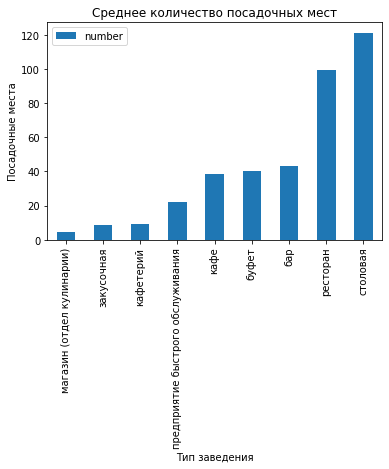

In [24]:
rest_data.groupby('new_object_type').agg({'number':'mean'}).sort_values(by='number').plot(kind='bar')
plt.legend() 
plt.title('Среднее количество посадочных мест') 
plt.ylabel('Посадочные места')
plt.xlabel('Тип заведения')

plt.show()

Больше всего посадочных мест в столовых, потому что им важен поток проходящих людей. Рестараны зачастую расчитаны на банкеты, поэтому там тоже часто встречается большое количество мест. Меньше всего посадочных мест в магазинах и закусочных.

**Выделение информации об улице, где находится заведение**

<a id='step_7'></a>

In [25]:
# с помощью регулярных выражений из адреса выделили навазние улиц и удалили оттуда слова схжие по смыслу с улицами(шоссе, проспект и тд)
pattern = '\,(([а-яА-Я0-9\ёй\s"]+)?(улица|шоссе|проспект|проезд|бульвар|переулок)([а-яА-Я0-9\ёй\s"]+)?)\,'
rest_data['street'] = rest_data['address'].str.extract(pat = pattern)[0]
rest_data['street_name'] = rest_data['street'].str.replace('улица|шоссе|проспект|проезд|бульвар|переулок','')
rest_data[['address', 'street', 'street_name']].query('~street.isna()').head(10)

,address,street,street_name
0,"город Москва, улица Егора Абакумова, дом 9",улица Егора Абакумова,Егора Абакумова
1,"город Москва, улица Талалихина, дом 2/1, корпус 1",улица Талалихина,Талалихина
3,"город Москва, Абрамцевская улица, дом 1",Абрамцевская улица,Абрамцевская
5,"город Москва, Абрамцевская улица, дом 15, корп...",Абрамцевская улица,Абрамцевская
6,"город Москва, переулок Сивцев Вражек, дом 6/2",переулок Сивцев Вражек,Сивцев Вражек
7,"город Москва, Авиамоторная улица, дом 8, строе...",Авиамоторная улица,Авиамоторная
8,"город Москва, Авиамоторная улица, дом 8, строе...",Авиамоторная улица,Авиамоторная
9,"город Москва, Авиамоторная улица, дом 8, строе...",Авиамоторная улица,Авиамоторная
10,"город Москва, Авиамоторная улица, дом 47",Авиамоторная улица,Авиамоторная
11,"город Москва, Авиамоторная улица, дом 49/1",Авиамоторная улица,Авиамоторная


**Топ-10 улиц по количеству объектов общественного питания**

<a id='step_8'></a>

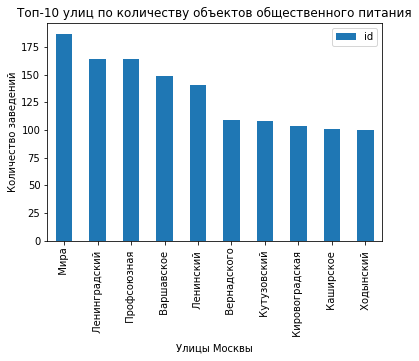

In [26]:
grouped_by_street = rest_data.groupby('street_name').agg({'id':'count'}).sort_values(by='id', ascending=False).head(10)
grouped_by_street.plot(kind='bar')
plt.legend() 
plt.title('Топ-10 улиц по количеству объектов общественного питания') 
plt.ylabel('Количество заведений')
plt.xlabel('Улицы Москвы')

plt.show()

Вручную производился поиск районов(справчник).

Эти улицы находтся в следующих районах города:

    - проспект Мира - на территории Северо-Восточного административного округа и Центрального административного округа города Москвы;
    - Ленинградский проспект - на территории Северного административного округа города Москвы;
    - улица Профсоюзная - на территории Юго-Западного административного округа города Москвы;
    - Варшавское шоссе - на территории Юго-Западного административного округа и Южного административного округа города Москвы;
    - Ленинский проспект - на территории Юго-Западного административного округа, Южного административного округа, Западного административного округа и Центрального административного округа города Москвы;
    - Вернадского проспект - на территории Юго-Западного административного округа и Западного административного округа города Москвы;
    - Кутузовский проспект - на территории Западного административного округа города Москвы;
    - Кировоградская улица - на территории Южного административного округа города Москвы;
    - Каширское шоссе - на территории Южного административного округа города Москвы;
    - Ходынский бульвар - на территории Северного административного округа города Москвы.

Большая часть улиц, из топ-10 по количеству заведений, расположена на юге и юго-западе столицы до МКАД. Северо-запад и северо-восток немного отстают от остальных районов города по количеству общепита. Но восток достаточно обделён.

**Найти число улиц с одним объектом общественного питания и в каких районах города они находятся**

<a id='step_9'></a>

In [27]:
grouped_by_street = rest_data.groupby('street').agg({'id':'count'}).sort_values(by='id', ascending=True).reset_index()
grouped_by_street_1 = grouped_by_street.query('id == 1')
grouped_by_street_1['street'] = grouped_by_street_1['street'].str.strip() 
grouped_by_street_1.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,street,id
0,улица Бориса Жигулёнкова,1
1,Фролов переулок,1
2,Фитарёвская улица,1
3,улица Гоголя,1
4,Икшинская улица,1


В Москве 422 улицы, на которых находится всего по одному заведению общественного питания. 

Импорт внешнего источника информации

In [28]:
from io import BytesIO
import requests
spreadsheet_id = '1653nOCTZd0GucX-S0mdBNxxsz0Kl9K6gFc2fAI6T7Qg'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
df = pd.read_csv(BytesIO(r.content))
df.head()

,streetname,areaid,okrug,area
0,Выставочный переулок,17,ЦАО,Пресненский район
1,улица Гашека,17,ЦАО,Пресненский район
2,Большая Никитская улица,17,ЦАО,Пресненский район
3,Глубокий переулок,17,ЦАО,Пресненский район
4,Большой Гнездниковский переулок,17,ЦАО,Пресненский район


In [29]:
# определение района, в котором находится улица, с помощью справочника
grouped_by_street_1 = grouped_by_street_1.merge(df, left_on='street', right_on='streetname', how='left')
grouped_by_street_1 = grouped_by_street_1.dropna()
grouped_by_street_1

,street,id,streetname,areaid,okrug,area
0,улица Бориса Жигулёнкова,1,улица Бориса Жигулёнкова,36.0,ВАО,Район Соколиная Гора
1,Фролов переулок,1,Фролов переулок,15.0,ЦАО,Красносельский район
3,улица Гоголя,1,улица Гоголя,53.0,Зеленоград,Панфиловский район
4,Икшинская улица,1,Икшинская улица,60.0,САО,Дмитровский район
5,улица Гончарова,1,улица Гончарова,74.0,СВАО,Бутырский район
...,...,...,...,...,...,...
457,Бумажный проезд,1,Бумажный проезд,55.0,САО,Район Беговой
458,Будайская улица,1,Будайская улица,81.0,СВАО,Район Ростокино
459,улица Медиков,1,улица Медиков,107.0,ЮАО,Район Царицыно
460,Спартаковский переулок,1,Спартаковский переулок,13.0,ЦАО,Басманный район


In [30]:
grouped_by_street = rest_data.groupby('street').agg({'id':'count'}).sort_values(by='id', ascending=False).reset_index()
grouped_by_street ['street'] = grouped_by_street['street'].str.strip() 
grouped_by_street = grouped_by_street.merge(df, left_on='street', right_on='streetname', how='left')
grouped_by_street = grouped_by_street.dropna()


grouped_by_street_3 = grouped_by_street.groupby('area').agg({'id':'count'}).sort_values(by='id', ascending=False)
print('В следующих районах больше всего заведений общепита:')
grouped_by_street_3.head(10)

В следующих районах больше всего заведений общепита:


,id
area,
Тверской район,78
Пресненский район,72
Басманный район,71
Таганский район,61
Район Хамовники,55
Мещанский район,42
Район Арбат,39
Даниловский район,32
Красносельский район,32


In [31]:
grouped_by_street_top_10 = grouped_by_street_1.groupby('area').agg({'id':'count'}).sort_values(by='id', ascending=True)
print('В следующих районах больше всего одна улица, на которой находится всего одно заведение общепита:')
grouped_by_street_top_10.head(10)


В следующих районах больше всего одна улица, на которой находится всего одно заведение общепита:


,id
area,
Район Крюково,1
Район Москворечье-Сабурово,1
Район Ново-Переделкино,1
Район Южное Медведково,1
Район Марьино,1
Район Восточный,1
Район Орехово-Борисово Северное,1
Обручевский район,1
Район Очаково-Матвеевское,1


In [32]:
print('В следующих районах больше всего улиц, на которых находится всего одно заведение общепита:')
grouped_by_street_top_10.tail(10)

В следующих районах больше всего улиц, на которых находится всего одно заведение общепита:


,id
area,
Район Люблино,8
Район Лефортово,9
Район Соколиная Гора,9
Район Арбат,15
Мещанский район,15
Тверской район,15
Район Хамовники,18
Пресненский район,19
Таганский район,20


**Распределение количества посадочных мест для улиц с большим количеством объектов общественного питания**

<a id='step_10'></a>

In [33]:
grouped_by_street = rest_data.groupby('street_name').agg({'id':'count'}).sort_values(by='id', ascending=False).reset_index().head(5)
top_10_streets_list = grouped_by_street['street_name'].to_list()
top_10_streets_list

['  Мира', ' Ленинградский ', ' Профсоюзная ', ' Варшавское ', ' Ленинский ']

Гистограммы количества посадочных мест на наиболее популярных улицах Москвы
  Мира


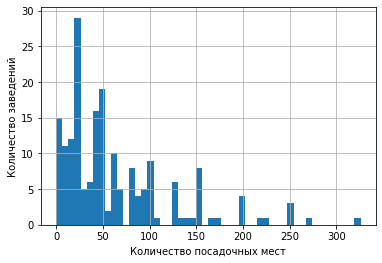

 Ленинградский 


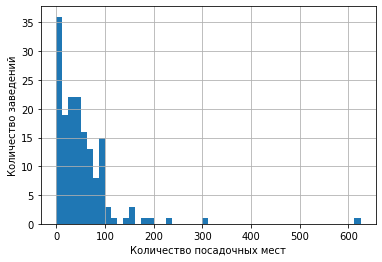

 Профсоюзная 


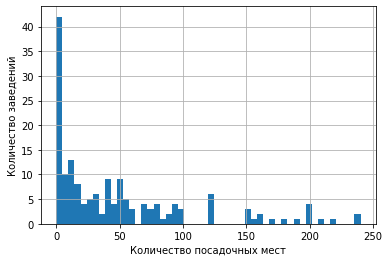

 Варшавское 


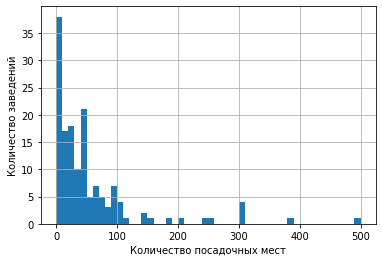

 Ленинский 


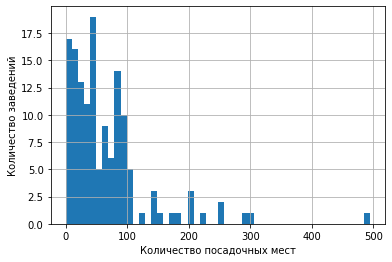

In [34]:
print('Гистограммы количества посадочных мест на наиболее популярных улицах Москвы')
for street in top_10_streets_list:
    rest_data.query('street_name == @street')['number'].hist(bins=50)
    print(street)
    plt.ylabel('Количество заведений')
    plt.xlabel('Количество посадочных мест')
    plt.show()

По большей части распределения количества посадочных мест на наиболее заполненных заведениями улицах подобны. Часто встречаются маленькие кафе или магазинчики, где может поместиться немного людей. На проспекте Мира картина немного отличается, возможно, потому что он относится к центральным улицам и там требуются заведения, в которых можно посадить больше гостей. В основном пользуются популярностью заведения вместимостью до 100 человек.

### Общий вывод

<a id='step_11'></a>

**Тип заведения**
    В Москве очень много разноплановых заведений. Но наиболее популярным остаётся кафе. Рестораны и столовые с роботами открывать сложно: слишком много роботов потребуется. Закусочные и бары - опасные места для роботов. Кафе - лучший выбор, роботы и обслужить помогут и посетителей позабавят.
    
**Количество посадочных мест**
    Среднее количество посадочных мест в кафе 40. Это оптимальное количество посадочных мест, которое можно охватить небольшим количеством роботов. Например, 5 роботов на 40 человек. 
    
**Расположение кафе**
    Такое кафе точно должно быть внутри МКАД. Район Арбата очень популярный среди туристов и посетителей, но дорогой для аренды помещения. Восточный и Юго-Восточный административные округи не сильно охвачены заведениями, но для старта это будет сложно. Если будет принято решение о преобразовании кафе в сеть, то можно податься туда. Предлагаю рассмотреть Южный, Юго-Западный, Северо-Западные округи для первого кафе. Также можно попробовать расположить кафе недалеко от Сколково или технического института, например, чтобы привлечь людей неравнодушных к робототехнике.  
    
Примеры улиц: улица Профсоюзная, Ленинский проспектб Кировоградская улица.
    
    

Презентация: <https://drive.google.com/file/d/1CfbaQRJD1u9Doy82epXqJoUmr6fn7zRF/view?usp=sharing>